In [349]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp

In [350]:
def rand_range(amin, amax):
    """Return a random number in the range [amin, amax]"""
    return amin + (amax - amin) * np.random.rand()


class EventFrameRandomAffine:
    def __init__(
        self,
        size=(260, 346),
        translate=(0.2, 0.2),
        degrees=15,
        scale=(0.8, 1.2),
        spatial_jitter=None,
        augment_flag=True,
    ):
        self.height, self.width = size
        self.translate = translate
        self.degrees = degrees
        self.scale = scale
        self.spatial_jitter = spatial_jitter
        self.augment_flag = augment_flag
        self.affine_matrix = self.get_affine_matrix()

    def normalize(self, coords, backward=False):
        """
        Normalize or denormalize the coordinates.

        Args:
            coords (np.ndarray): The coordinates to be normalized or denormalized.
                coords[0] -> x
                coords[1] -> y
            backward (bool): If True, denormalize the coordinates. Otherwise, normalize them.

        Returns:
            np.ndarray: The transformed coordinates.
        """
        if not backward:
            coords[0] = coords[0] / (self.width - 1) - 0.5
            coords[1] = coords[1] / (self.height - 1) - 0.5
        else:
            coords[0] = (coords[0] + 0.5) * (self.width - 1)
            coords[1] = (coords[1] + 0.5) * (self.height - 1)

        return coords

    def get_translation_matrix(self):
        translate = [rand_range(-t, t) for t in self.translate]
        T = np.array(
            [[1, 0, translate[0]], [0, 1, translate[1]], [0, 0, 1]], dtype=float
        )
        return T

    def get_rotation_matrix(self):
        degrees = rand_range(-self.degrees, self.degrees) / 180 * math.pi
        cos, sin = np.cos(degrees), np.sin(degrees)
        R = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]], dtype=float)
        return R

    def get_scale_matrix(self):
        scale = [rand_range(*self.scale) for _ in range(2)]
        S = np.array([[scale[0], 0, 0], [0, scale[1], 0], [0, 0, 1]], dtype=float)
        return S

    def get_affine_matrix(self):
        """
        Return the affine transformation matrix: A = TRS
        """
        T = self.get_translation_matrix()
        R = self.get_rotation_matrix()
        S = self.get_scale_matrix()
        A = np.dot(np.dot(T, R), S)
        return A
    
    def transform_event_frame(self, event_frame:np.array):
        assert event_frame.ndim == 3 or event_frame.ndim == 4
        if event_frame.ndim == 4:
            event_frame = np.moveaxis(event_frame, 0, 1)
        elif event_frame.ndim == 3:
            event_frame = np.expand_dims(event_frame, axis=0)
        t, c, h, w = event_frame.shape
        transform = AffineTransform(matrix=self.affine_matrix)
        for i in range(t):
            for j in range(c):
                event_frame[i, j] = warp(event_frame[i, j], transform, preserve_range=True, output_shape=(h, w))
        if event_frame.shape[0] == 1:
            event_frame = np.squeeze(event_frame, axis=0)
        else:
            event_frame = np.moveaxis(event_frame, 1, 0)
        return event_frame

    def transform_label(self, label:np.array):
        assert label.shape[0] == 2 and label.ndim == 2
        label_ones = np.ones((1, label.shape[1]))
        label_stacked = np.vstack((label, label_ones))
        label_affined = np.dot(self.affine_matrix, label_stacked)
        label = label_affined[:2]
        return label

In [351]:
height, width = 260, 346
canvas = np.zeros((height, width), dtype=np.uint8)
side_length = 100
center_y, center_x = height // 2, width // 2
start_x = center_x - side_length // 2
start_y = center_y - side_length // 2
canvas[start_y:start_y + side_length, start_x:start_x + side_length] = 255

In [352]:
canvas_copy = canvas.copy()
event_frame = np.stack([canvas_copy, canvas_copy], axis=0)
event_frame.shape

(2, 260, 346)

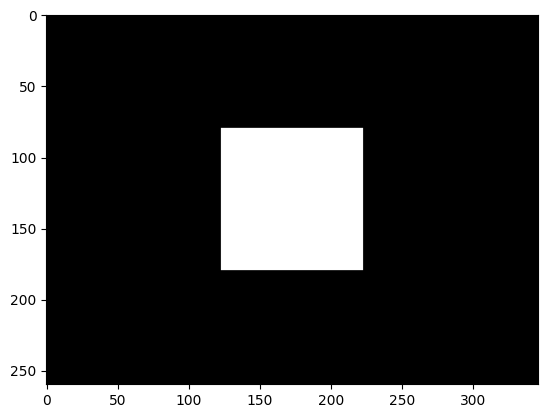

In [353]:
plt.imshow(canvas, cmap='gray')

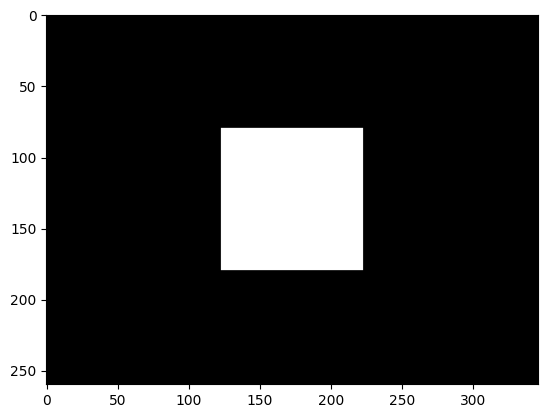

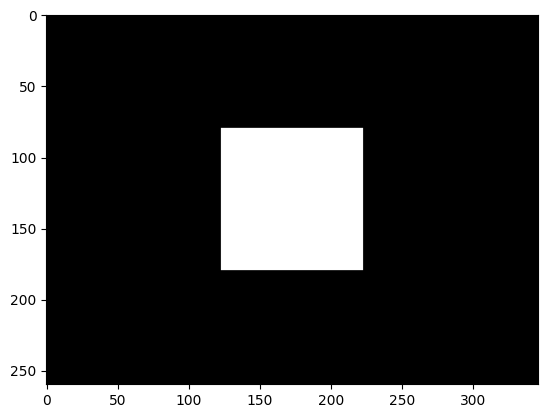

In [354]:
for i in range(event_frame.shape[0]):
    plt.imshow(event_frame[i], cmap='gray')
    plt.show()

In [355]:
augment = EventFrameRandomAffine()

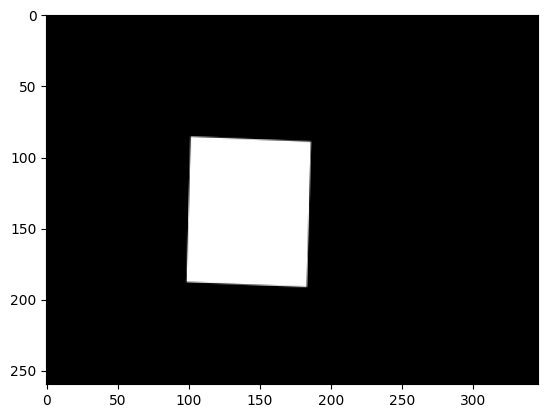

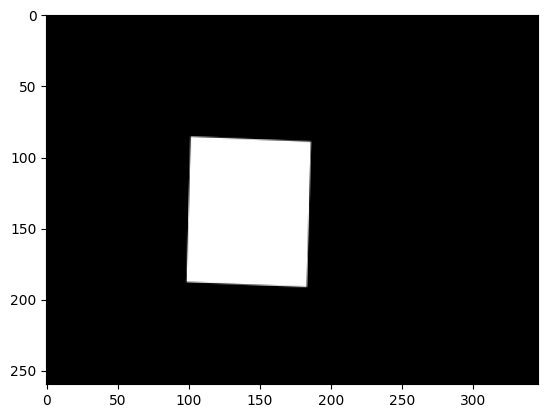

In [356]:
event_frame_aug = augment.transform_event_frame(event_frame)
for i in range(event_frame_aug.shape[0]):
    plt.imshow(event_frame_aug[i], cmap='gray')
    plt.show()

In [357]:
event_frame_time = np.stack([event_frame, event_frame, event_frame], axis=0)

In [358]:
event_frame_time.shape

(3, 2, 260, 346)

In [359]:
event_frame_time_aug = augment.transform_event_frame(event_frame_time)

In [360]:
event_frame_time_aug.shape

(3, 2, 260, 346)

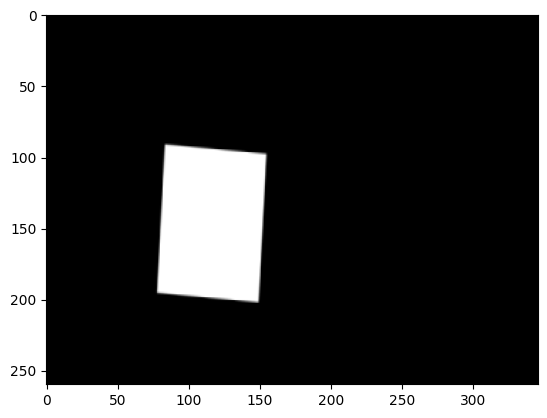

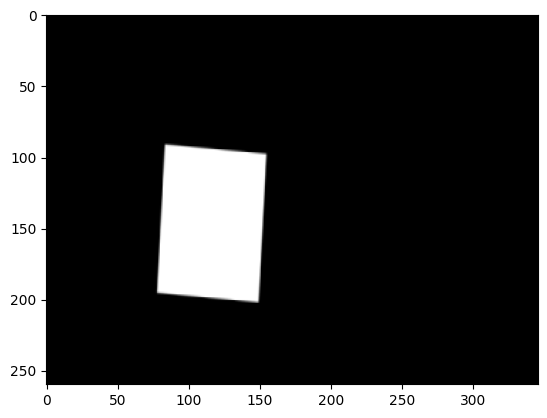

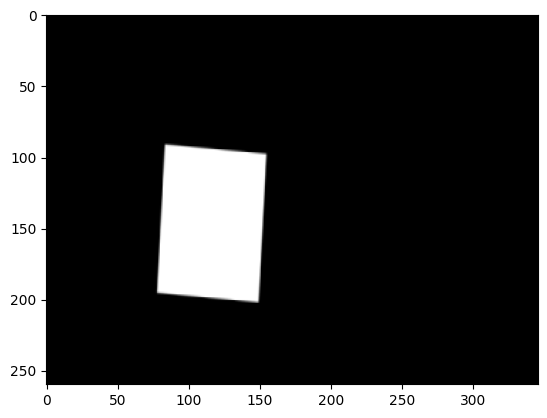

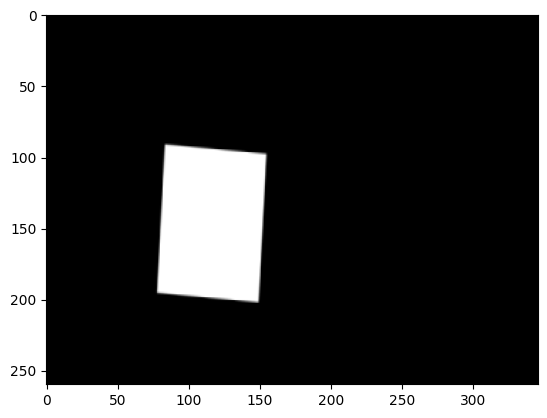

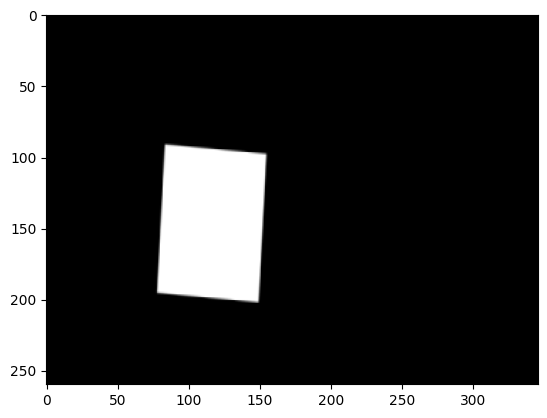

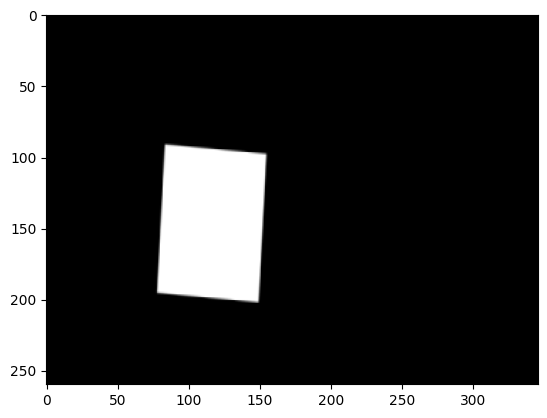

In [361]:
for i in range(event_frame_time_aug.shape[0]):
    for j in range(event_frame_time_aug.shape[1]):
        plt.imshow(event_frame_time_aug[i, j], cmap='gray')
        plt.show()

In [362]:
event_frame_time_aug.max()

255

In [363]:
transform = AffineTransform(matrix=augment.affine_matrix)
image = warp(canvas_copy, transform, preserve_range=True)

In [385]:
ones = np.ones((1, 50))
twos = np.ones((1, 50))
label = np.vstack((ones, twos))
ones.shape, twos.shape, label.shape

((1, 50), (1, 50), (2, 50))

In [373]:
label = augment.transform_label(twos)

In [374]:
label.shape

(2, 1)

In [366]:
transform.params

array([[ 1.18073122,  0.03396934,  0.04154773],
       [-0.041042  ,  0.97725896, -0.01167126],
       [ 0.        ,  0.        ,  1.        ]])

In [367]:
transform.inverse.params

array([[ 0.84591074, -0.0294037 , -0.03548885],
       [ 0.03552576,  1.02203536,  0.01045243],
       [ 0.        ,  0.        ,  1.        ]])

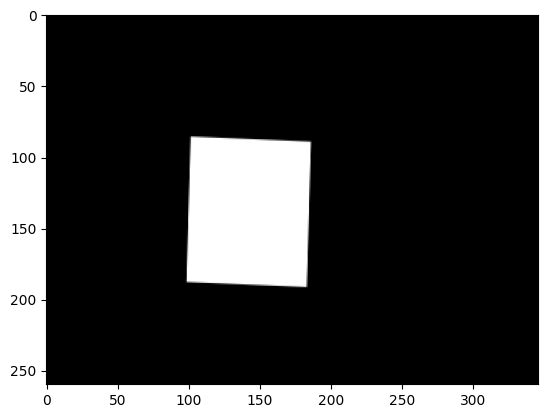

In [368]:
plt.imshow(image, cmap='gray')

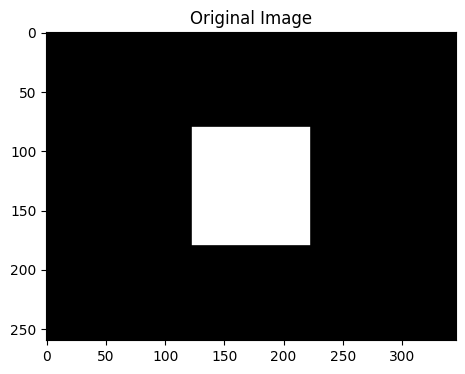

In [369]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp

# 创建一个黑色背景的图像
h, w = 260, 346
image = np.zeros((h, w), dtype=np.uint8)

# 填充中间的白色正方形
square_size = 100
top_left_y = (h - square_size) // 2
top_left_x = (w - square_size) // 2
image[top_left_y:top_left_y+square_size, top_left_x:top_left_x+square_size] = 255

plt.figure(figsize=(6, 4))
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.show()

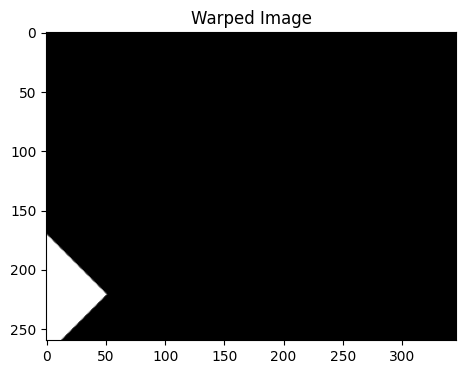

In [370]:
# 创建一个仿射变换矩阵，例如旋转、缩放和平移
tform = AffineTransform(
    scale=(0.8, 0.8),    # 缩放因子
    rotation=np.deg2rad(45),  # 旋转45度
    translation=(-30, 50)     # 平移
)

# 应用仿射变换
warped_image = warp(image, tform.inverse, output_shape=(h, w))

plt.figure(figsize=(6, 4))
plt.title("Warped Image")
plt.imshow(warped_image, cmap='gray')
plt.show()

In [380]:
arange = np.arange(2*3*2*2)
array = arange.reshape(2, 3, 2, 2)
array.shape

(2, 3, 2, 2)

In [382]:
array

array([[[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]],


       [[[12, 13],
         [14, 15]],

        [[16, 17],
         [18, 19]],

        [[20, 21],
         [22, 23]]]])

In [383]:
np.flip(array, axis=1)

array([[[[ 8,  9],
         [10, 11]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 0,  1],
         [ 2,  3]]],


       [[[20, 21],
         [22, 23]],

        [[16, 17],
         [18, 19]],

        [[12, 13],
         [14, 15]]]])